# Transfer Learning Notebook, Dr. Dimitris Mousadakos

We will be using a pre-trained MobileNetV2 model to classify images of cats and dogs.

### **1. Setup and Imports**

First, let's import the necessary libraries. We'll need `torch`, `torchvision`, `matplotlib`, and a few others.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, models, transforms
import requests
import zipfile
from pathlib import Path
from tqdm.notebook import tqdm
import gdown

### **2. Data Download and Preprocessing**

We'll download the "cats and dogs" dataset, which is a filtered version of the original dataset from Kaggle.

In [3]:
# 1. Download the dataset using the File ID
# We extract the ID from your URL: 19xX_Fr2x6NPlifcagIjxqUSWLE3Wtafw
file_id = '19xX_Fr2x6NPlifcagIjxqUSWLE3Wtafw'
url = f'https://drive.google.com/uc?id={file_id}'
output = 'cats_and_dogs.zip'

gdown.download(url, output, quiet=False)

# 2. Extract the dataset
# We check if the file is a valid zip before extracting
if zipfile.is_zipfile(output):
    print("Extracting files...")
    with zipfile.ZipFile(output, 'r') as zip_ref:
        zip_ref.extractall()
    print("Extraction complete.")
else:
    print("Error: The downloaded file is not a valid zip file.")

# 3. Define paths
PATH = Path('cat-and-dog-small/')
train_dir = PATH / 'training_set'
validation_dir = PATH / 'test_set'

Downloading...
From (original): https://drive.google.com/uc?id=19xX_Fr2x6NPlifcagIjxqUSWLE3Wtafw
From (redirected): https://drive.google.com/uc?id=19xX_Fr2x6NPlifcagIjxqUSWLE3Wtafw&confirm=t&uuid=705ee6fb-ddfe-4df2-bc93-09c4393b93ac
To: /Users/dmousadakos/Library/CloudStorage/GoogleDrive-dmousadakos@bigblue.ai/My Drive/Teaching/HSLU/CVI03 - Blockweek/Computer Vision day 2/Exercises/cats_and_dogs.zip
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 114M/114M [00:03<00:00, 31.9MB/s]


Extracting files...
Extraction complete.


Now, we'll set up data augmentation and loaders for our training and validation sets. Data augmentation is a key technique to prevent overfitting in computer vision tasks. 🖼️

In [4]:
# Image size and batch size
IMG_SIZE = (160, 160)
BATCH_SIZE = 32

# Data augmentation and normalization for training
# and just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(IMG_SIZE),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(IMG_SIZE),
        transforms.CenterCrop(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Load the datasets
image_datasets = {
    'train': datasets.ImageFolder(train_dir, data_transforms['train']),
    'val': datasets.ImageFolder(validation_dir, data_transforms['val'])
}

# Create dataloaders
dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=BATCH_SIZE, shuffle=True),
    'val': DataLoader(image_datasets['val'], batch_size=BATCH_SIZE)
}

class_names = image_datasets['train'].classes
print(f"Classes: {class_names}")

Classes: ['cats', 'dogs']


Let's visualize some of the training images to get a feel for the data.



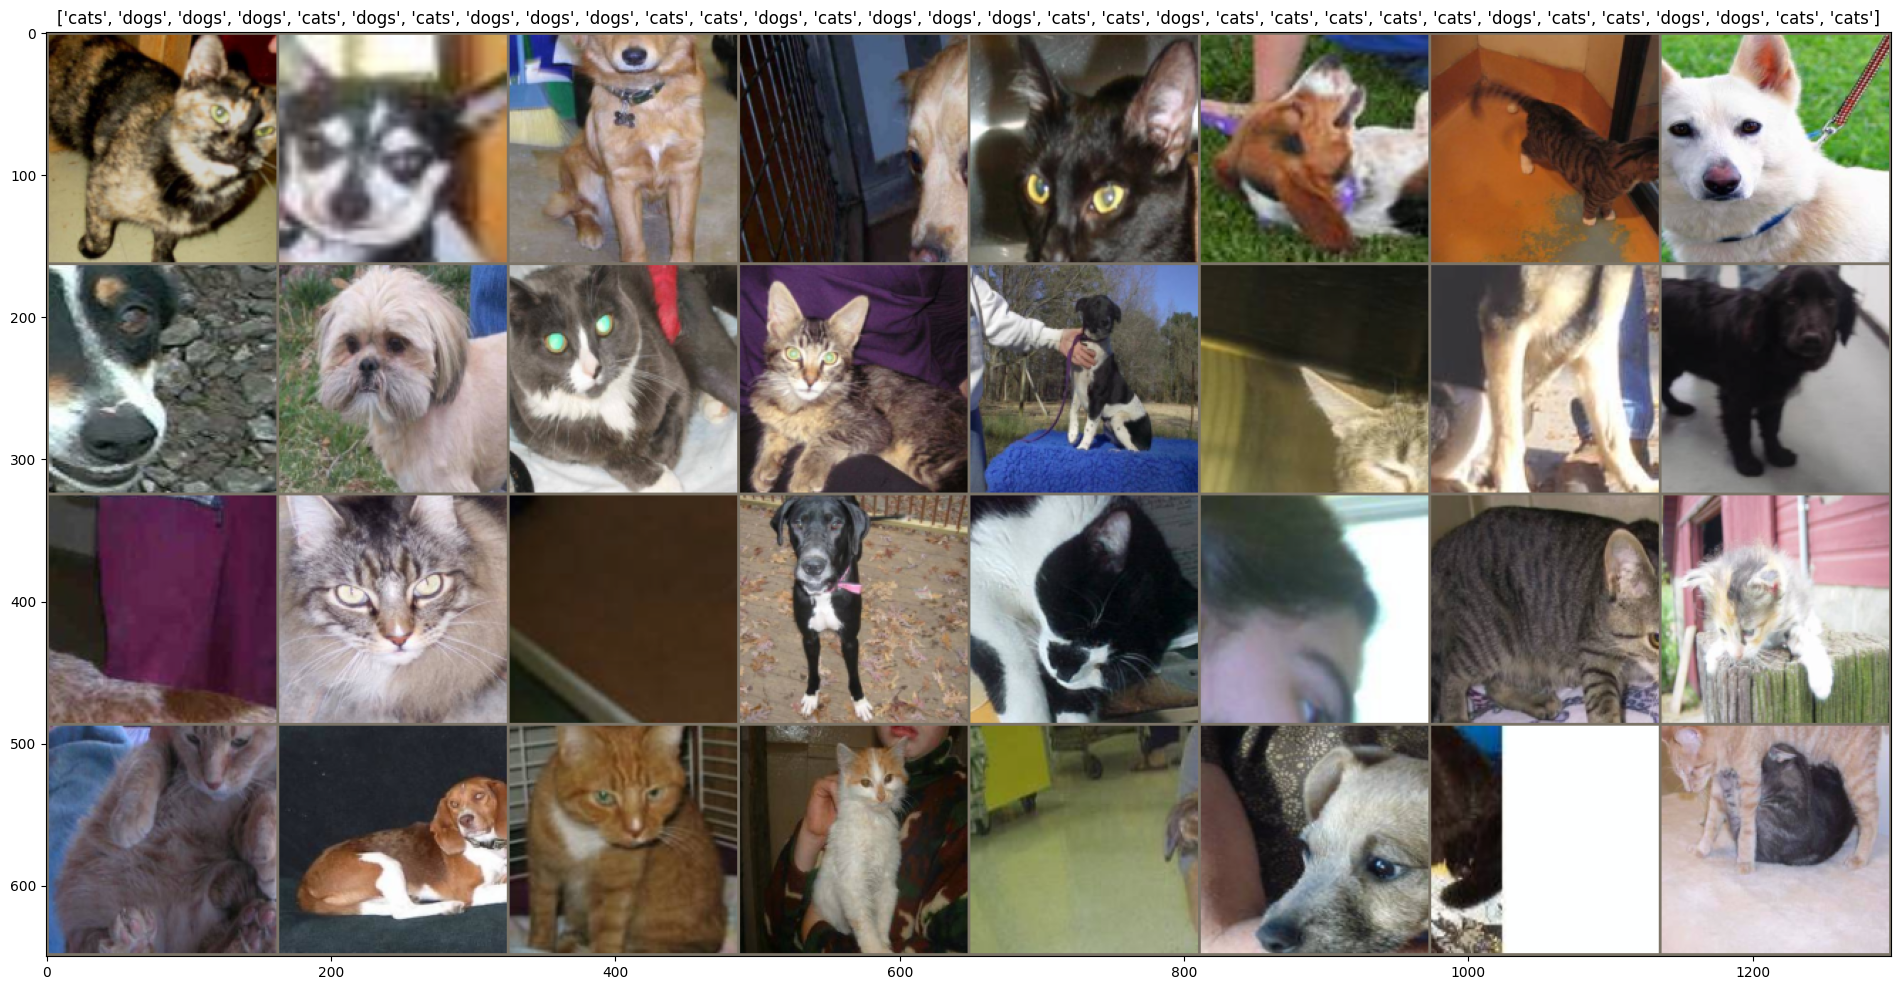

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    figsize=(50, 12)
    plt.figure(figsize=figsize)
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch and show images
from torchvision.utils import make_grid
out = make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [6]:
# Load the pre-trained model
base_model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)

# Freeze the convolutional base
for param in base_model.parameters():
    param.requires_grad = False

# Create a new classifier
base_model.classifier[1] = nn.Linear(base_model.last_channel, len(class_names))

# Move the model to the GPU if available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("✅ Using NVIDIA GPU (CUDA)")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("✅ Using Apple Silicon GPU (MPS)")
else:
    device = torch.device("cpu")
    print("✅ Using CPU")

# Move the model to the selected device
model = base_model.to(device)

print(model.classifier)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /Users/dmousadakos/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13.6M/13.6M [00:00<00:00, 17.3MB/s]


✅ Using Apple Silicon GPU (MPS)
Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=1280, out_features=2, bias=True)
)


### **4. Training the Model**

Here's the training loop. We'll train for 10 epochs and observe the validation accuracy.

In [7]:
def train_model(model, criterion, optimizer, num_epochs=10):
    # Initialize a dictionary to store training history
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Use tqdm to create a progress bar
            progress_bar = tqdm(dataloaders[phase], desc=f'{phase.capitalize()} Epoch {epoch}')

            # Iterate over data.
            for inputs, labels in progress_bar:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward pass + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
                # Update progress bar with live accuracy
                progress_bar.set_postfix(
                    loss=running_loss / ((progress_bar.n + 1) * dataloaders[phase].batch_size),
                    # CORRECTED LINE: Used .float() instead of .double()
                    acc=running_corrects.float() / ((progress_bar.n + 1) * dataloaders[phase].batch_size)
                )

            epoch_loss = running_loss / len(image_datasets[phase])
            # CORRECTED LINE: Used .float() instead of .double()
            epoch_acc = running_corrects.float() / len(image_datasets[phase])

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Record the loss and accuracy for this epoch
            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())
                
    return model, history

In [8]:
criterion = nn.CrossEntropyLoss()
# Pass all parameters of the simple_model to the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [9]:
model, history = train_model(model, criterion, optimizer, num_epochs=10)

Epoch 0/9
----------


Train Epoch 0:   0%|          | 0/126 [00:00<?, ?it/s]

train Loss: 0.3304 Acc: 0.8574


Val Epoch 0:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.1743 Acc: 0.9269
Epoch 1/9
----------


Train Epoch 1:   0%|          | 0/126 [00:00<?, ?it/s]

train Loss: 0.2452 Acc: 0.8941


Val Epoch 1:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.1289 Acc: 0.9545
Epoch 2/9
----------


Train Epoch 2:   0%|          | 0/126 [00:00<?, ?it/s]

train Loss: 0.2210 Acc: 0.9033


Val Epoch 2:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.1304 Acc: 0.9466
Epoch 3/9
----------


Train Epoch 3:   0%|          | 0/126 [00:00<?, ?it/s]

train Loss: 0.2151 Acc: 0.9088


Val Epoch 3:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.1192 Acc: 0.9555
Epoch 4/9
----------


Train Epoch 4:   0%|          | 0/126 [00:00<?, ?it/s]

train Loss: 0.2172 Acc: 0.9043


Val Epoch 4:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.1096 Acc: 0.9605
Epoch 5/9
----------


Train Epoch 5:   0%|          | 0/126 [00:00<?, ?it/s]

train Loss: 0.2083 Acc: 0.9048


Val Epoch 5:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.1105 Acc: 0.9575
Epoch 6/9
----------


Train Epoch 6:   0%|          | 0/126 [00:00<?, ?it/s]

train Loss: 0.2161 Acc: 0.9003


Val Epoch 6:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.1062 Acc: 0.9585
Epoch 7/9
----------


Train Epoch 7:   0%|          | 0/126 [00:00<?, ?it/s]

train Loss: 0.1969 Acc: 0.9108


Val Epoch 7:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.1083 Acc: 0.9555
Epoch 8/9
----------


Train Epoch 8:   0%|          | 0/126 [00:00<?, ?it/s]

train Loss: 0.2054 Acc: 0.9113


Val Epoch 8:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.1089 Acc: 0.9585
Epoch 9/9
----------


Train Epoch 9:   0%|          | 0/126 [00:00<?, ?it/s]

train Loss: 0.2167 Acc: 0.9003


Val Epoch 9:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.1058 Acc: 0.9545


In [10]:
def plot_history(history):
    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

    # --- Plot training & validation accuracy values ---
    ax1.plot(history['train_acc'], label='Train Accuracy', marker='o')
    ax1.plot(history['val_acc'], label='Validation Accuracy', marker='o')
    ax1.set_title('Model Accuracy Over Epochs', fontsize=16)
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(loc='lower right')
    ax1.grid(True)

    # --- Plot training & validation loss values ---
    ax2.plot(history['train_loss'], label='Train Loss', marker='o')
    ax2.plot(history['val_loss'], label='Validation Loss', marker='o')
    ax2.set_title('Model Loss Over Epochs', fontsize=16)
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(loc='upper right')
    ax2.grid(True)

    plt.show()

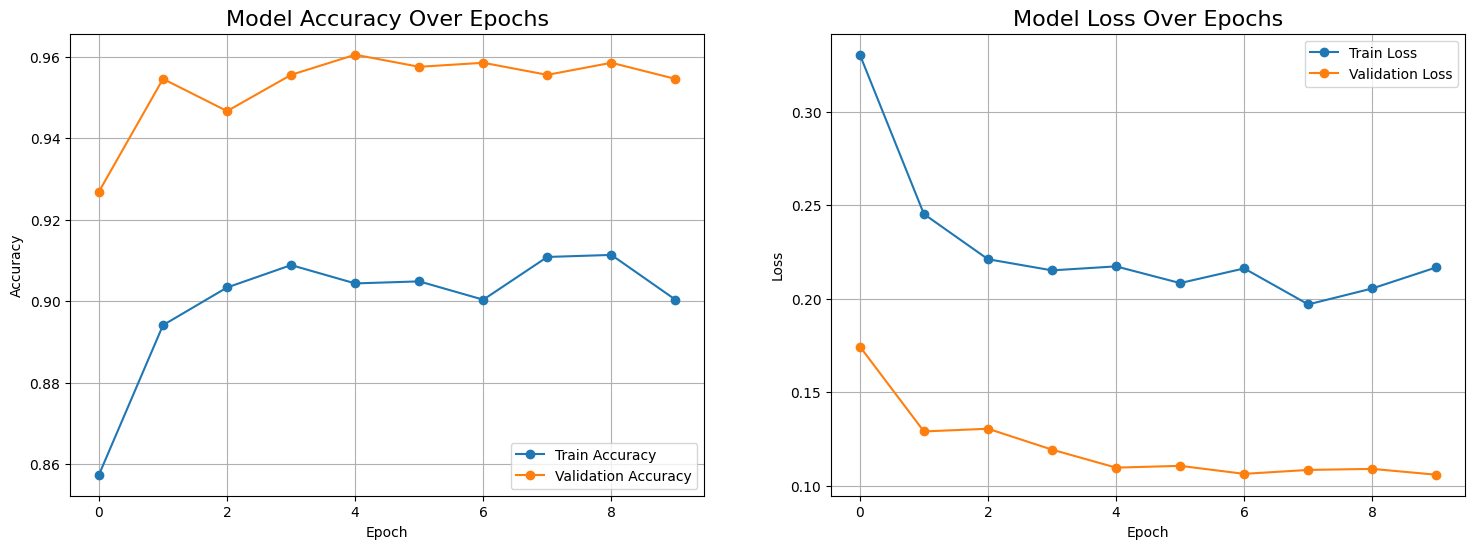

In [11]:
plot_history(history)

In [12]:
model.eval()

# Initialize counters for correct predictions and total samples
total_correct = 0
total_samples = 0

# Disable gradient calculations for efficiency
with torch.no_grad():
    # Use tqdm for a progress bar
    progress_bar = tqdm(dataloaders['val'], desc='Validating')
    
    for inputs, labels in progress_bar:
        # Move data to the same device as the model
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass to get outputs
        outputs = model(inputs)

        # Get the predicted class with the highest score
        _, predictions = torch.max(outputs, 1)

        # Update the total number of samples
        total_samples += labels.size(0)
        
        # Update the total number of correct predictions
        total_correct += (predictions == labels).sum().item()

# Calculate the final validation accuracy
validation_accuracy = (total_correct / total_samples) * 100

# Print the final result
print("\n" + "="*50)
print(f"Final Validation Accuracy: {validation_accuracy:.2f}%")
print(f"Correctly classified {total_correct} out of {total_samples} images.")
print("="*50)

Validating:   0%|          | 0/32 [00:00<?, ?it/s]


Final Validation Accuracy: 95.45%
Correctly classified 966 out of 1012 images.


### **5. Fine-Tuning**

Now, we'll unfreeze some of the top layers of the pre-trained model and continue training with a lower learning rate. This is called fine-tuning and can often improve performance.

In [13]:
# Unfreeze some layers
for param in base_model.features[-5:].parameters():
    param.requires_grad = True

# Re-compile with a lower learning rate
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Continue training
model, history = train_model(model, criterion, optimizer, num_epochs=5)

Epoch 0/4
----------


Train Epoch 0:   0%|          | 0/126 [00:00<?, ?it/s]

train Loss: 0.1866 Acc: 0.9153


Val Epoch 0:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0850 Acc: 0.9615
Epoch 1/4
----------


Train Epoch 1:   0%|          | 0/126 [00:00<?, ?it/s]

train Loss: 0.1652 Acc: 0.9258


Val Epoch 1:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0829 Acc: 0.9605
Epoch 2/4
----------


Train Epoch 2:   0%|          | 0/126 [00:00<?, ?it/s]

train Loss: 0.1571 Acc: 0.9316


Val Epoch 2:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0762 Acc: 0.9674
Epoch 3/4
----------


Train Epoch 3:   0%|          | 0/126 [00:00<?, ?it/s]

train Loss: 0.1410 Acc: 0.9423


Val Epoch 3:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0784 Acc: 0.9664
Epoch 4/4
----------


Train Epoch 4:   0%|          | 0/126 [00:00<?, ?it/s]

train Loss: 0.1297 Acc: 0.9471


Val Epoch 4:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 0.0684 Acc: 0.9733


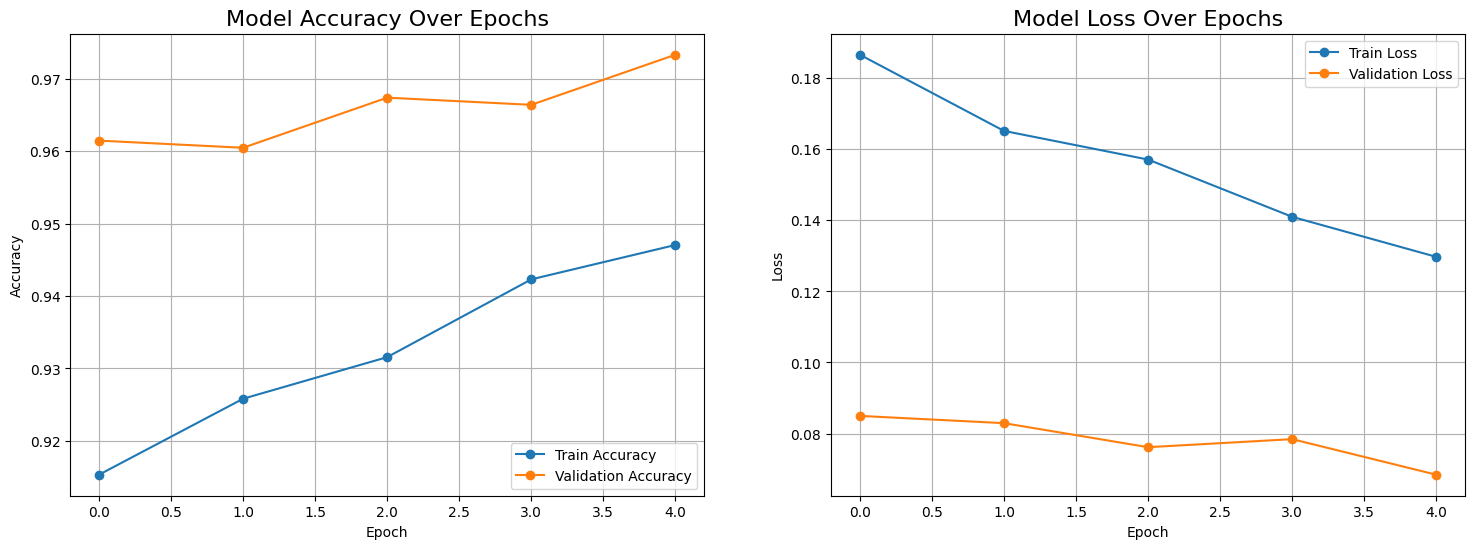

In [14]:
plot_history(history)

In [15]:
model.eval()

# Initialize counters for correct predictions and total samples
total_correct = 0
total_samples = 0

# Disable gradient calculations for efficiency
with torch.no_grad():
    # Use tqdm for a progress bar
    progress_bar = tqdm(dataloaders['val'], desc='Validating')
    
    for inputs, labels in progress_bar:
        # Move data to the same device as the model
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass to get outputs
        outputs = model(inputs)

        # Get the predicted class with the highest score
        _, predictions = torch.max(outputs, 1)

        # Update the total number of samples
        total_samples += labels.size(0)
        
        # Update the total number of correct predictions
        total_correct += (predictions == labels).sum().item()

# Calculate the final validation accuracy
validation_accuracy = (total_correct / total_samples) * 100

# Print the final result
print("\n" + "="*50)
print(f"Final Validation Accuracy: {validation_accuracy:.2f}%")
print(f"Correctly classified {total_correct} out of {total_samples} images.")
print("="*50)

Validating:   0%|          | 0/32 [00:00<?, ?it/s]


Final Validation Accuracy: 97.33%
Correctly classified 985 out of 1012 images.


### **6. Evaluation and Prediction**

Let's see how our model performs on a few validation images.

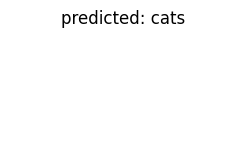

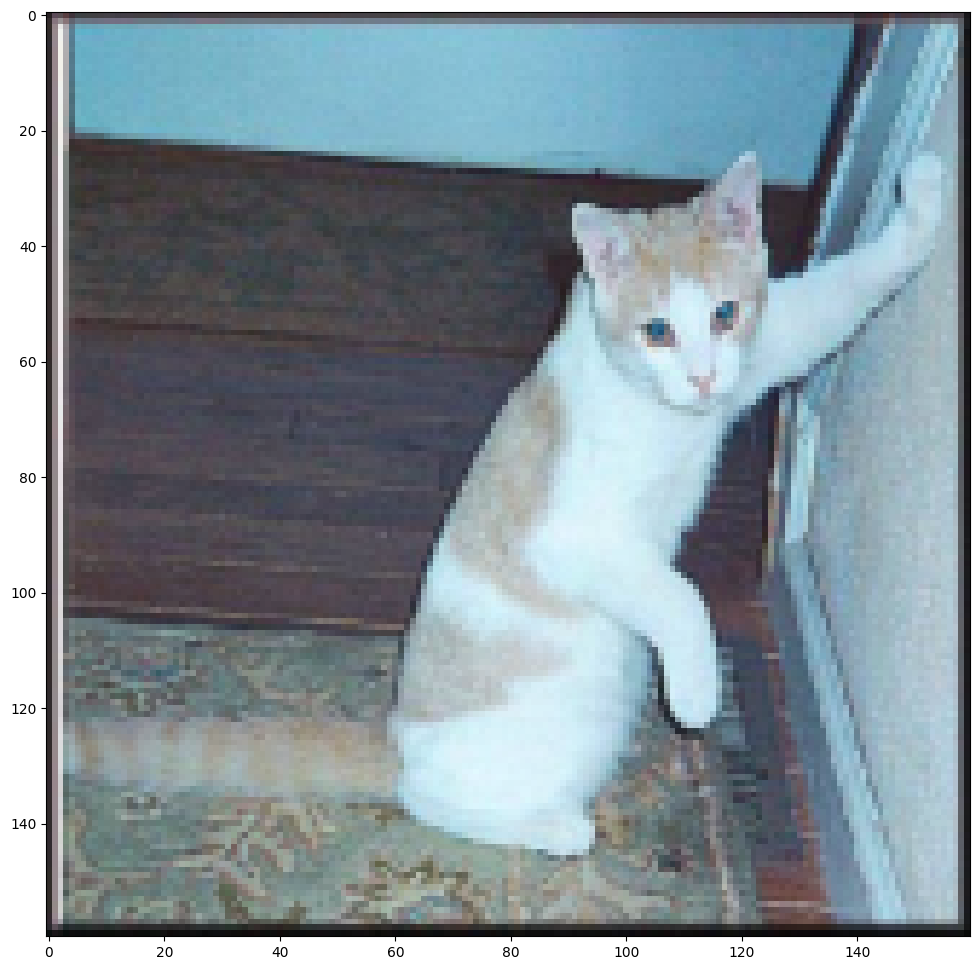

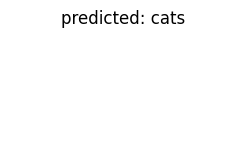

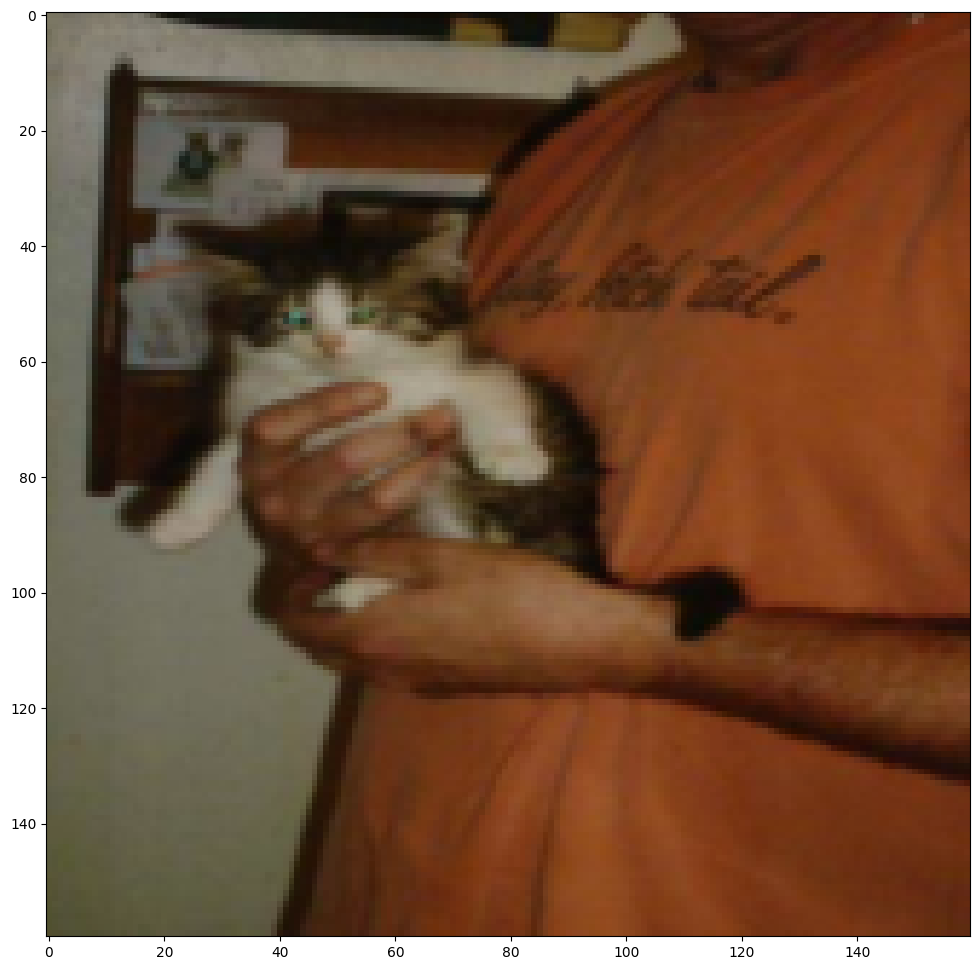

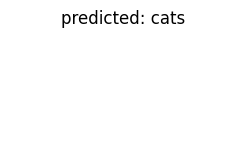

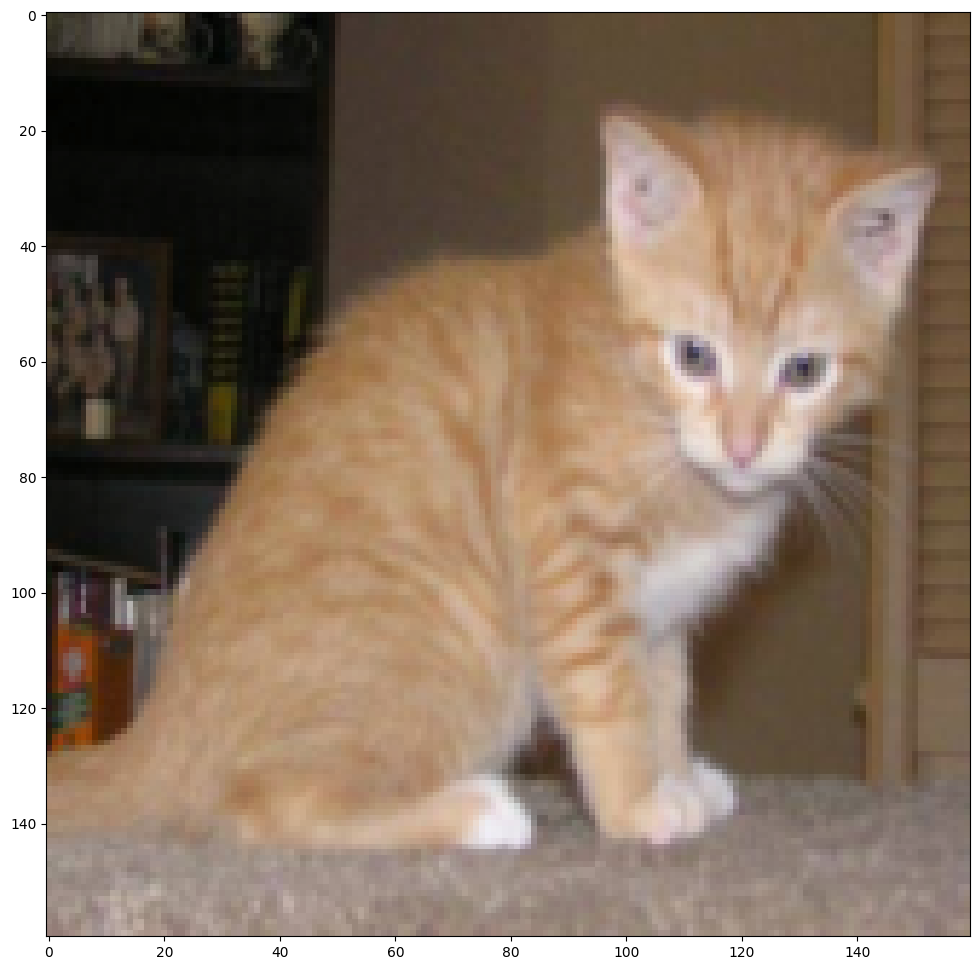

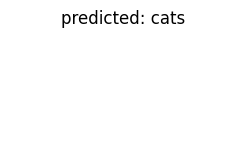

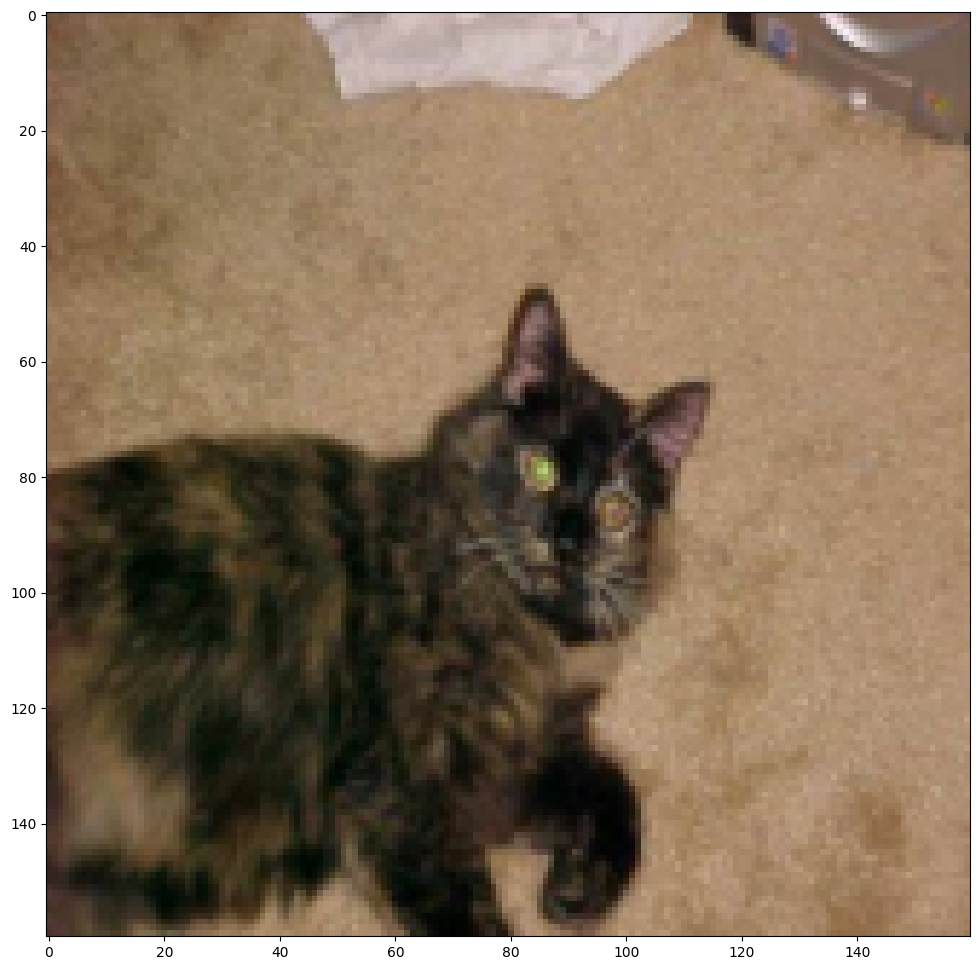

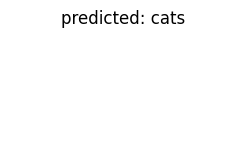

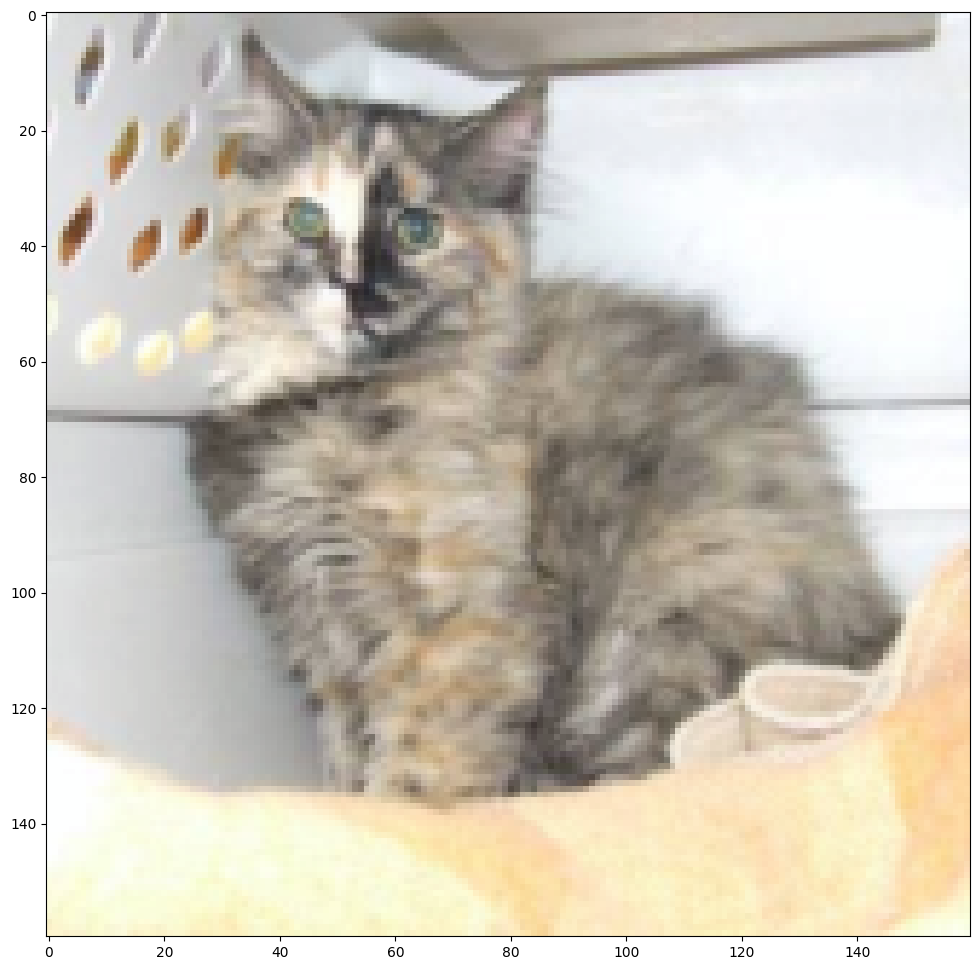

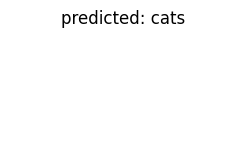

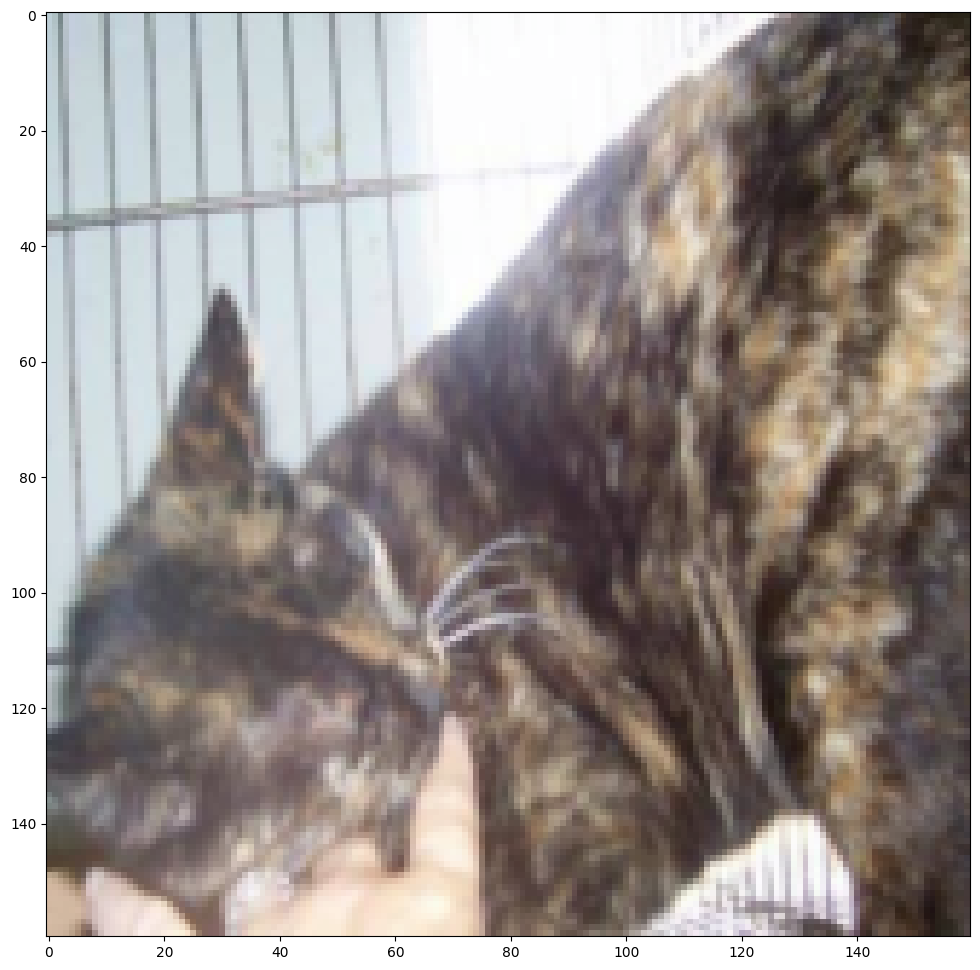

In [16]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

visualize_model(model)

### **🧠 Further Questions and Exercises**

Here are some additional questions to deepen your understanding of transfer learning:

1. **Experiment with Different Models:** Replace MobileNetV2 with another pre-trained model from `torchvision.models`, such as **ResNet18** or **VGG16**. How does the performance and training time change?
2. **Adjust the Number of Frozen Layers:** Try unfreezing more or fewer layers during the fine-tuning stage. How does this affect the model's accuracy and training stability?
3. **Hyperparameter Tuning:** Experiment with different learning rates and batch sizes. What combination gives you the best results?
4. **Data Augmentation:** Add more data augmentation techniques, like `transforms.ColorJitter` or `transforms.RandomRotation`. Does this improve the model's ability to generalize?
5. **Confusion Matrix:** Create a confusion matrix to visualize the model's performance in more detail. Which class does the model have more trouble with? Why do you think that is?
6. **Split the dataset to train, validation, test. Use the test dataset to get the accuracy.